In [149]:
# Assignment 12

# Decision Tree Classification

In [150]:
import pandas as pd

df = pd.read_excel('heart_disease.xlsx',sheet_name='Heart_disease')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [152]:
df['oldpeak'].isnull().sum()

np.int64(62)

In [153]:
# imputaion

df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

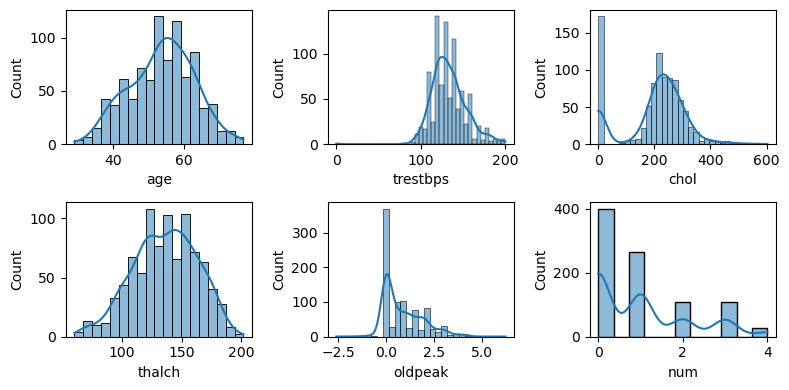

In [154]:
# plotting histogram

import matplotlib.pyplot as plt
import seaborn as sns

num_feats = df.select_dtypes(['int64','float64']).columns

plt.figure(figsize=(8,4))

for i,col in enumerate(num_feats,1):
    plt.subplot(2,3,i)
    sns.histplot(df[col],kde=True)

plt.tight_layout()

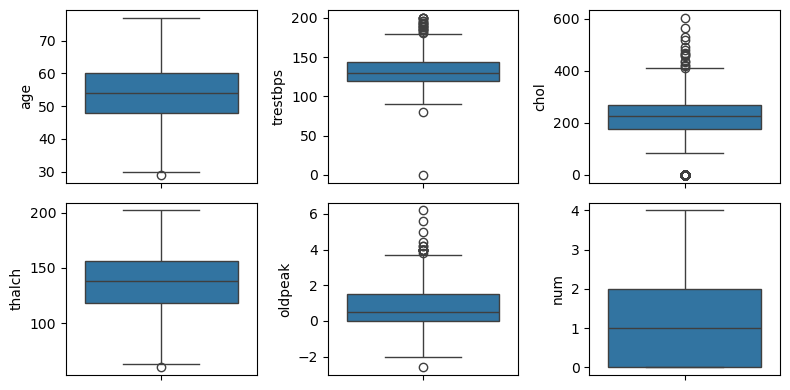

In [155]:
# plotting boxplot

plt.figure(figsize=(8,4))

for i,col in enumerate(num_feats,1):
    plt.subplot(2,3,i)
    sns.boxplot(df[col])

plt.tight_layout()

<Axes: >

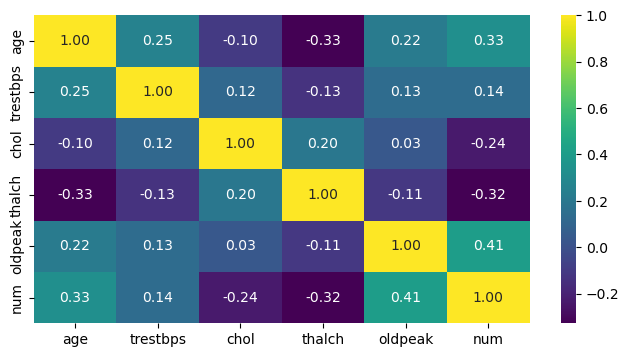

In [156]:
# heatmap

plt.figure(figsize=(8,4))

num_df = pd.DataFrame(df.select_dtypes(exclude='object'),columns=num_feats)

sns.heatmap(num_df.corr(),annot=True,fmt='.2f',cmap='viridis')

In [157]:
for col in df.select_dtypes('object').columns:
    print(col ,df[col].unique())

sex ['Male' 'Female']
cp ['typical angina' 'atypical angina' 'asymptomatic' 'non-anginal']
restecg ['lv hypertrophy' 'normal' 'st-t abnormality']
exang [False True 'FALSE' 'TURE']
slope ['downsloping' 'flat' 'upsloping']
thal ['fixed defect' 'normal' 'reversable defect']


In [158]:
df['exang'] = df['exang'].astype(str).str.upper().replace('TURE', 'TRUE')

df['slope'] = df['slope'].map({'downsloping': 0, 'flat': 1, 'upsloping': 2})

In [159]:
# train-test split

from sklearn.model_selection import train_test_split

X = df.drop(['num'], axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

In [160]:
# feature engneering

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_cols = X.select_dtypes('object').columns
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

In [161]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

transformer = ColumnTransformer([
    ('ohe', cat_pipe, cat_cols),
    ('scaler', num_pipe, num_cols)
], remainder='passthrough')

X_train_t = transformer.fit_transform(X_train)
X_test_t = transformer.transform(X_test)

In [162]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

model = DecisionTreeClassifier(random_state=38) 

model.fit(X_train_t, y_train)

y_pred = model.predict(X_test_t)

y_proba = model.predict_proba(X_test_t)

print(f'Accuracy Score: {accuracy_score(y_test, y_pred):.2f}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')

print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr"):.2f}\n')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Accuracy Score: 0.48

Confusion Matrix:
[[52 15  5  6  1]
 [16 23  8  8  1]
 [ 3  4  5  2  1]
 [ 4  9  8  6  1]
 [ 1  1  0  1  1]]

ROC AUC Score: 0.61

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        79
           1       0.44      0.41      0.43        56
           2       0.19      0.33      0.24        15
           3       0.26      0.21      0.24        28
           4       0.20      0.25      0.22         4

    accuracy                           0.48       182
   macro avg       0.36      0.37      0.36       182
weighted avg       0.49      0.48      0.48       182



In [168]:
# hyperparameters tunning

from sklearn.model_selection import GridSearchCV

params = {
    'criterion':['gini','entropy','log_loss'],
    'splitter':['random','best'],
    'max_depth':[3,4,5,6]
}

grid = GridSearchCV(
    model,
    param_grid=params,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train_t,y_train)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
Best CV Score: 0.5634293811998111


In [170]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_t)

y_proba = best_model.predict_proba(X_test_t)
auc = roc_auc_score(y_test, y_proba,multi_class="ovr")
print(f"ROC AUC Score: {auc:.3f}")

print(f"accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC AUC Score: 0.649
accuracy: 0.544
Confusion Matrix:
 [[62 12  4  1  0]
 [20 27  6  2  1]
 [ 4  7  3  1  0]
 [ 5  8  8  7  0]
 [ 0  1  3  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73        79
           1       0.49      0.48      0.49        56
           2       0.12      0.20      0.15        15
           3       0.64      0.25      0.36        28
           4       0.00      0.00      0.00         4

    accuracy                           0.54       182
   macro avg       0.39      0.34      0.35       182
weighted avg       0.55      0.54      0.53       182



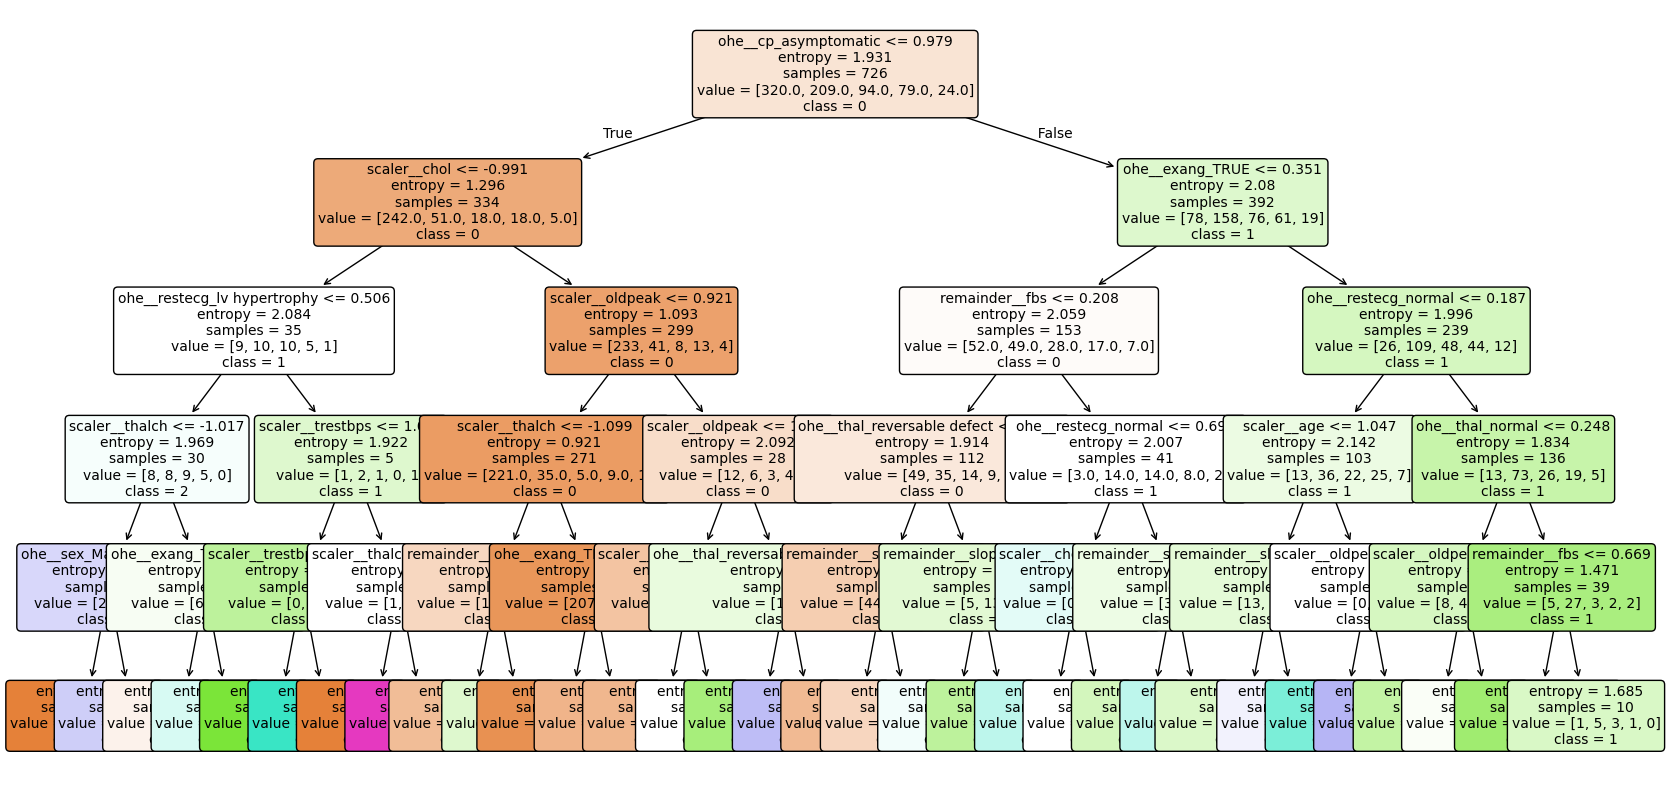

In [172]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    best_model,                 
    feature_names=transformer.get_feature_names_out(),  
    class_names=[str(c) for c in best_model.classes_], 
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

#### Interview Questions

1. Tuning the hyperparameters of a Decision Tree is crucial because they directly control the model’s complexity, bias–variance tradeoff, and interpretability.

   - criterion ("gini", "entropy", "log_loss") : Defines how the tree measures the “purity” of a split.
        - "gini" : (default) faster, often similar to entropy
        - "entropy" : uses information gain
        - "log_loss" : more probabilistic
   - max_depth : Maximum depth (levels) of the tree.
        - Too high : tree overfits (memorizes training set)
        - Too low : tree underfits (misses important patterns)
        - Common range : 3–20
   - splitter ("best", "random") : Strategy for choosing the split at each node
        - "best" : greedily chooses the best split (default)
        - "random" : randomly selects a split (adds randomness, useful for ensembles)
   - min_samples_split : Minimum number of samples required to split a node
        - Small values : deeper trees, risk of overfitting
        - Larger values : more conservative splits, smoother decision boundaries

2. Label encoder vs One-Hot encoder

    - Label Encoder :
      - Each category is replaced with a single integer
      - ex : ['red', 'green', 'blue', 'green'] >> [2, 1, 0, 1] in ALPHABETICAL order
      - Tree-based models (Decision Tree, Random Forest, XGBoost), since they don’t assume order in numbers.
    - One-Hot encoder :
      - Creates a binary column per category
      - ex : red : [0,0,1] , green : [0,1,0] , blue : [1,0,0] in ALPHABETICAL order
      - Linear models , NNs